# OOD Performance assessment

In [3]:
import glob
import os
import pickle
import numpy as np
import pandas as pd
import scanpy as sc
import tqdm
import gc
import os
import numpy as np
import pandas as pd
import scanpy as sc
import glob
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import issparse

def get_R(data1,data2,dim=1,func=pearsonr):
    adata1=data1.X
    adata2=data2.X

    # Check if the variables are sparse matrices or numpy arrays
    adata2 = adata2.toarray() if issparse(adata2) else adata2
    
    r1,p1=[],[]
    for g in range(data1.shape[dim]):
        if dim==1:
            r,pv=func(adata1[:,g],adata2[:,g], alternative='greater')
        elif dim==0:
            r,pv=func(adata1[g,:],adata2[g,:], alternative='greater')
        r1.append(r)
        p1.append(pv)
    r1=np.array(r1)
    p1=np.array(p1)
    return r1,p1

def get_ssim(data1, data2, num_breaks=None):
    """
    Some info about SSIM computation.
    data1: the ground truth data
    data2: the predicted data
    dim: the dimension to calculate the SSIM. If the dim = 1, calculate the SSIM at gene-wise, otherwise calculate the SSIM at spot-wise.
    """
    adata1 = data1.X
    adata2 = data2.X

    # Check if the variables are sparse matrices or numpy arrays
    adata1 = adata1.toarray() if issparse(adata1) else adata1
    adata2 = adata2.toarray() if issparse(adata2) else adata2

    SSIM = []
    for g in range(adata1.shape[1]):
        x = adata1[:,g]
        y = adata2[:,g]
        # Normalize the arrays if their maximum values are not zero
        x = x if np.max(x) == 0 else x / np.max(x)
        y = y if np.max(y) == 0 else y / np.max(y)  
    
        if num_breaks:
            # Discretize the normalized arrays into 'num_breaks' bins
            x = np.digitize(x, np.linspace(0, 1, num_breaks), right=False) - 1
            y = np.digitize(y, np.linspace(0, 1, num_breaks), right=False) - 1
            
            # Constants used in SSIM calculation
            C1 = (0.01 * (num_breaks - 1))**2
            C2 = (0.03 * (num_breaks - 1))**2
        else:
            C1 = (0.01)**2
            C2 = (0.03)**2
        
        mux = np.mean(x)
        muy = np.mean(y) 
        sigxy = np.cov(x, y)[0, 1]
        sigx = np.var(x)
        sigy = np.var(y)
        
        ssim = ((2 * mux * muy + C1) * (2 * sigxy + C2)) / ((mux**2 + muy**2 + C1) * (sigx + sigy + C2))
        SSIM.append(ssim)
        assert -1 <= ssim <= 1, "SSIM should be within the valid range [-1, 1]"
        
    return SSIM

def get_cosine(data1, data2):
    # Convert the anndata to numpy array
    adata1=data1.X.T
    adata2=data2.X.T
    # Calculate the consine similarity at gene wise
    cosine_sim = cosine_similarity(adata1, adata2)
    # Take the diag of similarity matrix
    cosine_score = np.diag(cosine_sim)
    return cosine_score

def make_res(source_dataset, target_dataset, methods, names, ensemble=True):
    RESULTS_DIR = "../Results/Generalizability"
    SUMMARY_DIR = "../Results/Summary/Generalizability"

    if ensemble:
        model_no = "mean"
    else:
        model_no = 0

    for method in tqdm.tqdm(methods):
        for name in names:
            gc.collect()
            file_path = os.path.join(RESULTS_DIR, f"{source_dataset}_{target_dataset}", "ensemble", f"pred_{method}_{source_dataset}_{target_dataset}_{name}_{model_no}.h5ad")

            if os.path.exists(file_path):
                data1 = sc.read_h5ad(os.path.join(RESULTS_DIR, f"{source_dataset}_{target_dataset}", f"gt_{method}_{source_dataset}_{target_dataset}_{name}.h5ad"))
                data2 = sc.read_h5ad(file_path)
                spatial_matrix = np.load(os.path.join(RESULTS_DIR, f"{source_dataset}_{target_dataset}", f"spatial_loc_{method}_{source_dataset}_{target_dataset}_{name}_func.npy"))
                data2.var_names = data1.var_names
                pcc, PCC_PValue = get_R(data1, data2, dim=1, func=pearsonr)
                spc, SPC_PValue = get_R(data1, data2, dim=1, func=spearmanr)
                ssim_score = get_ssim(data1, data2)
                cosine_score = get_cosine(data1, data2)

                PCC_BC_Visium = {
                    "Gene": list(data1.var_names),
                    "Pearson correlation": pcc,
                    "PCC_PValue": PCC_PValue,
                    "Spearmanr correlation": spc,
                    "SPC_PValue": SPC_PValue,
                    "SSIM_Score": ssim_score,
                    "Cosine_Score": cosine_score,
                    "Slides": [name] * len(pcc),
                    "Dataset": [f"{source_dataset}_{target_dataset}"] * len(pcc),
                    "Method": [method] * len(pcc),
                }

                pcc_bc_visium = pd.DataFrame(PCC_BC_Visium)
                summary_dir = os.path.join(SUMMARY_DIR, f"{source_dataset}_{target_dataset}")

                if not os.path.exists(summary_dir):
                    os.mkdir(summary_dir)

                pcc_bc_visium.to_csv(os.path.join(RESULTS_DIR, f"{source_dataset}_{target_dataset}", f"{method}_{source_dataset}_{target_dataset}_{name}_nonMI.csv"))
            else:
                print(f"The file {file_path} does not exist. Skipping.")

    print("Organize the results into summary file!")
    res = glob.glob(os.path.join(RESULTS_DIR, f"{source_dataset}_{target_dataset}", "*_nonMI.csv"))
    df = pd.concat([pd.read_csv(i, index_col=[0]) for i in res])

    summary_dir = os.path.join(SUMMARY_DIR, f"{source_dataset}_{target_dataset}")

    if not os.path.exists(summary_dir):
        os.mkdir(summary_dir)

    df.to_csv(os.path.join(SUMMARY_DIR, f"{source_dataset}_{target_dataset}_summary_nonMI_{model_no}.csv"))
    return df

def top_predictable_genes(df_results: pd.DataFrame, dataset: str, method: str, num: int = 5) -> pd.DataFrame:
    """
    Extracts the top predictable genes based on Pearson correlation for a specific method and dataset.

    Parameters:
        - df_results (pd.DataFrame): The DataFrame containing the results from the make_res function.
        - dataset (str): The dataset name.
        - method (str): The method name.
        - num (int, optional): The number of top predictable genes or "pos" for all positive Pearson correlation values.

    Returns:
        pd.DataFrame: DataFrame containing the top predictable genes and related statistics.
    """
    df = df_results[df_results["Method"] == method]

    if num == "pos":
        top_df = df[["Gene", "Pearson correlation"]].groupby("Gene", as_index=False).agg(
            ['median', 'mean', 'max', 'min', 'std']
        ).sort_values(by=('Pearson correlation', 'median'), ascending=False)
    else:
        top_df = df[["Gene", "Pearson correlation"]].groupby("Gene", as_index=False).agg(
            ['median', 'mean', 'max', 'min', 'std']
        ).sort_values(by=('Pearson correlation', 'median'), ascending=False).head(num)

    top_genes = list(top_df.index)

    # Calculate the number of consistent samples for each top gene
    num_pos = [df[df["Gene"] == g]['Pearson correlation'].gt(0).sum() for g in top_genes]

    # Create the final DataFrame with relevant columns
    top_df["Number of consistent samples"] = num_pos
    top_df["Method"] = method
    top_df["Dataset"] = dataset
    top_df = top_df[[('Method', ''), ('Dataset', ''), ('Number of consistent samples', ''),
                     ('Pearson correlation', 'mean'), ('Pearson correlation', 'median'),
                     ('Pearson correlation', 'min'), ('Pearson correlation', 'max'),
                     ('Pearson correlation', 'std')]]

    return top_df


In [4]:
methods = ["deeppt", "hist2st", "histogene", "stimage", "stnet", "deepspace", "bleep"]

for dataset_name in ["BC_Her2ST_BC_visium"]: # "BC_visium_BC_Her2ST", "Skin_cSCC_BC_Her2ST", "Skin_cSCC_Skin_Melanoma", "Skin_Melanoma_BC_visium"
    folder_path = f"../Results/Generalizability/{dataset_name}/ensemble"
    if not os.path.exists(folder_path):
        try:
            os.makedirs(folder_path)
            print(f"Directory '{folder_path}' created successfully.")
        except OSError as e:
            print(f"Error creating directory '{folder_path}': {e}")
    else:
        print(f"Directory '{folder_path}' already exists.")

    if dataset_name == "BC_visium_BC_Her2ST":
        names = list(set([i.split("_")[-2] for i in glob.glob(f"../Results/BC_Her2ST/gt_stimage_BC_Her2ST_reinhard*h5ad")]))
    if dataset_name == "Skin_cSCC_BC_Her2ST":
        names = list(set([i.split("_")[-2] for i in glob.glob(f"../Results/BC_Her2ST/gt_stimage_BC_Her2ST_reinhard*h5ad")]))
    if dataset_name == "Skin_cSCC_Skin_Melanoma":
        names = ["Visium29_B1", "Visium29_C1", "Visium37_D1", "Visium38_B1", "Visium38_D1"]
    if dataset_name == "Skin_Melanoma_BC_visium":
        names = ["1142243F", "1160920F", "CID4290", "CID4465", "CID44971", "CID4535", "FFPE", "block1", "block2"]
    if dataset_name == "BC_Her2ST_BC_visium":
        names = ["1142243F", "1160920F", "CID4290", "CID4465", "CID44971", "CID4535", "FFPE", "block1", "block2"]
    names.sort()

    for method in methods:
        for slide in names:
            adatas = np.array([sc.read_h5ad(r).to_df().values for r in glob.glob(f"../Results/Generalizability/{dataset_name}/pred_{method}_{dataset_name}_{slide}*.h5ad")])
            pred_mean = sc.AnnData(np.mean(adatas, axis=0))
            pred_var = sc.AnnData(np.var(adatas, axis=0))
            pred_mean.write_h5ad(f"../Results/Generalizability/{dataset_name}/ensemble/pred_{method}_{dataset_name}_{slide}_mean.h5ad")
            pred_var.write_h5ad(f"../Results/Generalizability/{dataset_name}/ensemble/pred_{method}_{dataset_name}_{slide}_var.h5ad")
            print(f"Saved ensemble predictions for {method} on {slide}.")


Directory '../Results/Generalizability/BC_Her2ST_BC_visium/ensemble' already exists.
Saved ensemble predictions for deeppt on 1142243F.
Saved ensemble predictions for deeppt on 1160920F.
Saved ensemble predictions for deeppt on CID4290.
Saved ensemble predictions for deeppt on CID4465.
Saved ensemble predictions for deeppt on CID44971.
Saved ensemble predictions for deeppt on CID4535.
Saved ensemble predictions for deeppt on FFPE.
Saved ensemble predictions for deeppt on block1.
Saved ensemble predictions for deeppt on block2.
Saved ensemble predictions for hist2st on 1142243F.
Saved ensemble predictions for hist2st on 1160920F.
Saved ensemble predictions for hist2st on CID4290.
Saved ensemble predictions for hist2st on CID4465.
Saved ensemble predictions for hist2st on CID44971.
Saved ensemble predictions for hist2st on CID4535.
Saved ensemble predictions for hist2st on FFPE.
Saved ensemble predictions for hist2st on block1.
Saved ensemble predictions for hist2st on block2.
Saved ense

In [84]:
# for dataset_name in ["Skin_Melanoma2Skin_cSCC", "BC_visium_BC_Her2ST", "Skin_Melanoma_BC_visium", "Skin_cSCC_BC_Her2ST", "Skin_cSCC_Skin_Melanoma"]:
#     for method in ["deeppt", "hist2st", "histogene", "stimage", "stnet", "deepspace", "bleep"]:
#         print(dataset_name, method)
#         print(len(glob.glob(f"../Results/Generalizability/{dataset_name}/pred_{method}*.h5ad")))
        

## Skin_Melanoma2BC_visium

In [35]:
source_dataset = "Skin_Melanoma"
target_dataset = "BC_visium"

if target_dataset == "Kidney_visium":
    names = ["A", "B", "C", "D", "Visium14_C", "Visium14_D"]
elif target_dataset == "BC_Her2ST":
    names = list(set([i.split("_")[-2] for i in glob.glob(f"../Results/{target_dataset}/gt_stimage_{target_dataset}_reinhard*h5ad")]))
elif target_dataset == "BC_visium":
    names = ["1142243F", "1160920F", "CID4290", "CID4465", "CID44971", "CID4535", "FFPE", "block1", "block2"]
elif target_dataset == "Skin_Melanoma":
    names = ["Visium29_B1", "Visium29_C1", "Visium37_D1", "Visium38_B1", "Visium38_D1"]
elif target_dataset == "Skin_cSCC":
    names = ['P2_ST_rep1', 'P2_ST_rep2', 'P2_ST_rep3', 'P5_ST_rep1', 
         'P5_ST_rep2', 'P5_ST_rep3', 'P9_ST_rep1', 'P9_ST_rep2', 
         'P9_ST_rep3', 'P10_ST_rep1', 'P10_ST_rep2', 'P10_ST_rep3']
elif target_dataset == "Liver_visium":
    names = ["C73_A1_VISIUM", "C73_B1_VISIUM", "C73_C1_VISIUM", "C73_D1_VISIUM"]
    
Methods = ["deeppt", "hist2st", "histogene", "stimage", "stnet", "deepspace", "bleep"]


df = make_res(source_dataset, target_dataset, Methods, names, ensemble=True)


  0%|          | 0/7 [00:00<?, ?it/s]/opt/anaconda3/envs/torch2py38/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/opt/anaconda3/envs/torch2py38/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/opt/anaconda3/envs/torch2py38/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/opt/anaconda3/envs/torch2py38/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/opt/anaconda3/envs/t

Organize the results into summary file!


In [ ]:
df

,Gene,Pearson correlation,PCC_PValue,Spearmanr correlation,SPC_PValue,SSIM_Score,Cosine_Score,Slides,Dataset,Method
0,FES,-0.026041,0.903474,-0.029620,0.930640,-0.004218,0.488529,FFPE,Skin_Melanoma_BC_visium,stimage
1,APH1B,0.012852,0.260343,0.025707,0.099408,0.022406,0.423996,FFPE,Skin_Melanoma_BC_visium,stimage
2,LILRB2,-0.074153,0.999897,-0.071475,0.999826,-0.041146,0.551916,FFPE,Skin_Melanoma_BC_visium,stimage
3,GADD45G,0.057445,0.002032,0.050870,0.005481,0.035930,0.310049,FFPE,Skin_Melanoma_BC_visium,stimage
4,EPAS1,0.042605,0.016579,0.068341,0.000314,0.040738,0.742672,FFPE,Skin_Melanoma_BC_visium,stimage
...,...,...,...,...,...,...,...,...,...,...
1205,SLIT2,0.097110,0.001055,0.090746,0.002039,0.024577,0.295243,CID4535,Skin_Melanoma_BC_visium,bleep
1206,PIK3R2,0.026494,0.201321,0.016894,0.296806,0.031053,0.679061,CID4535,Skin_Melanoma_BC_visium,bleep
1207,LYN,-0.036995,0.878760,-0.034287,0.860640,-0.011830,0.421807,CID4535,Skin_Melanoma_BC_visium,bleep
1208,TSPAN7,-0.089829,0.997764,-0.065580,0.980935,-0.006430,0.228490,CID4535,Skin_Melanoma_BC_visium,bleep


## SkincSCC2Skin_Melanoma

In [ ]:
# ls ../Results/Generalizability/Skin_Melanoma2Skin_cSCC

In [ ]:
source_dataset = "Skin_cSCC"
target_dataset = "Skin_Melanoma"

if target_dataset == "Kidney_visium":
    names = ["A", "B", "C", "D", "Visium14_C", "Visium14_D"]
elif target_dataset == "BC_Her2ST":
    names = list(set([i.split("_")[-2] for i in glob.glob(f"../Results/{dataset_name}/gt_stimage_{dataset_name}_reinhard*h5ad")]))
elif target_dataset == "BC_visium":
    names = ["1142243F", "1160920F", "CID4290", "CID4465", "CID44971", "CID4535", "FFPE", "block1", "block2"]
elif target_dataset == "Skin_Melanoma":
    names = ["Visium29_B1", "Visium29_C1", "Visium37_D1", "Visium38_B1", "Visium38_D1"]
elif target_dataset == "Skin_cSCC":
    names = ['P2_ST_rep1', 'P2_ST_rep2', 'P2_ST_rep3', 'P5_ST_rep1', 
         'P5_ST_rep2', 'P5_ST_rep3', 'P9_ST_rep1', 'P9_ST_rep2', 
         'P9_ST_rep3', 'P10_ST_rep1', 'P10_ST_rep2', 'P10_ST_rep3']
elif target_dataset == "Liver_visium":
    names = ["C73_A1_VISIUM", "C73_B1_VISIUM", "C73_C1_VISIUM", "C73_D1_VISIUM"]
    
Methods = ["deeppt", "hist2st", "histogene", "stimage", "stnet", "deepspace", "bleep"]

df = make_res(source_dataset, target_dataset, Methods, names, ensemble=True)


In [28]:
glob.glob("../Results/Generalizability/*_*_*_*")

['../Results/Generalizability/Skin_cSCC_Skin_Melanoma',
 '../Results/Generalizability/BC_visium_BC_Her2ST',
 '../Results/Generalizability/Skin_Melanoma_BC_visium',
 '../Results/Generalizability/Skin_cSCC_BC_Her2ST']

In [ ]:
df

,Gene,Pearson correlation,PCC_PValue,Spearmanr correlation,SPC_PValue,SSIM_Score,Cosine_Score,Slides,Dataset,Method
0,C1QB,-0.033963,0.865935,-0.043351,0.921278,0.006575,0.131071,P9_ST_rep2,Skin_Melanoma_Skin_cSCC,deepspace
1,ITGB7,-0.014295,0.679385,-0.010634,0.635563,0.017267,0.026645,P9_ST_rep2,Skin_Melanoma_Skin_cSCC,deepspace
2,PDGFB,-0.026616,0.807229,-0.023256,0.775820,0.012509,0.104104,P9_ST_rep2,Skin_Melanoma_Skin_cSCC,deepspace
3,PDGFRA,-0.017543,0.716295,-0.000268,0.503479,0.013266,0.092634,P9_ST_rep2,Skin_Melanoma_Skin_cSCC,deepspace
4,EIF4A2,-0.063526,0.980904,-0.065281,0.983421,-0.015762,0.221867,P9_ST_rep2,Skin_Melanoma_Skin_cSCC,deepspace
...,...,...,...,...,...,...,...,...,...,...
1101,BAX,-0.069694,0.958540,-0.066968,0.952142,-0.008180,0.168945,P10_ST_rep2,Skin_Melanoma_Skin_cSCC,histogene
1102,SHC3,-0.037349,0.823410,-0.027336,0.751558,-0.000843,0.115090,P10_ST_rep2,Skin_Melanoma_Skin_cSCC,histogene
1103,ZC3H12A,0.034899,0.192837,0.033844,0.200104,0.009998,0.258671,P10_ST_rep2,Skin_Melanoma_Skin_cSCC,histogene
1104,BMPR1B,-0.027343,0.751617,-0.035346,0.810195,0.000097,0.061851,P10_ST_rep2,Skin_Melanoma_Skin_cSCC,histogene


## Skin_cSCC_BC_Her2ST

In [ ]:
# ls ../Results/Generalizability/

In [22]:
source_dataset = "Skin_cSCC"
target_dataset = "BC_Her2ST"

if target_dataset == "Kidney_visium":
    names = ["A", "B", "C", "D", "Visium14_C", "Visium14_D"]
elif target_dataset == "BC_Her2ST":
    names = list(set([i.split("_")[-2] for i in glob.glob(f"../Results/{target_dataset}/gt_stimage_{target_dataset}_reinhard*h5ad")]))
elif target_dataset == "BC_visium":
    names = ["1142243F", "1160920F", "CID4290", "CID4465", "CID44971", "CID4535", "FFPE", "block1", "block2"]
elif target_dataset == "Skin_Melanoma":
    names = ["Visium29_B1", "Visium29_C1", "Visium37_D1", "Visium38_B1", "Visium38_D1"]
elif target_dataset == "Skin_cSCC":
    names = ['P2_ST_rep1', 'P2_ST_rep2', 'P2_ST_rep3', 'P5_ST_rep1', 
         'P5_ST_rep2', 'P5_ST_rep3', 'P9_ST_rep1', 'P9_ST_rep2', 
         'P9_ST_rep3', 'P10_ST_rep1', 'P10_ST_rep2', 'P10_ST_rep3']
elif target_dataset == "Liver_visium":
    names = ["C73_A1_VISIUM", "C73_B1_VISIUM", "C73_C1_VISIUM", "C73_D1_VISIUM"]
    
Methods = ["deeppt", "hist2st", "histogene", "stimage", "stnet", "deepspace", "bleep"]

df = make_res(source_dataset, target_dataset, Methods, names, ensemble=True)


  0%|          | 0/7 [00:00<?, ?it/s]/opt/anaconda3/envs/torch2py38/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/opt/anaconda3/envs/torch2py38/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/opt/anaconda3/envs/torch2py38/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/opt/anaconda3/envs/torch2py38/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/opt/anaconda3/envs/t

Organize the results into summary file!


In [ ]:
df

,Gene,Pearson correlation,PCC_PValue,Spearmanr correlation,SPC_PValue,SSIM_Score,Cosine_Score,Slides,Dataset,Method
0,C1QB,-0.033963,0.865935,-0.043351,0.921278,0.006575,0.131071,P9_ST_rep2,Skin_Melanoma_Skin_cSCC,deepspace
1,ITGB7,-0.014295,0.679385,-0.010634,0.635563,0.017267,0.026645,P9_ST_rep2,Skin_Melanoma_Skin_cSCC,deepspace
2,PDGFB,-0.026616,0.807229,-0.023256,0.775820,0.012509,0.104104,P9_ST_rep2,Skin_Melanoma_Skin_cSCC,deepspace
3,PDGFRA,-0.017543,0.716295,-0.000268,0.503479,0.013266,0.092634,P9_ST_rep2,Skin_Melanoma_Skin_cSCC,deepspace
4,EIF4A2,-0.063526,0.980904,-0.065281,0.983421,-0.015762,0.221867,P9_ST_rep2,Skin_Melanoma_Skin_cSCC,deepspace
...,...,...,...,...,...,...,...,...,...,...
1101,BAX,-0.069694,0.958540,-0.066968,0.952142,-0.008180,0.168945,P10_ST_rep2,Skin_Melanoma_Skin_cSCC,histogene
1102,SHC3,-0.037349,0.823410,-0.027336,0.751558,-0.000843,0.115090,P10_ST_rep2,Skin_Melanoma_Skin_cSCC,histogene
1103,ZC3H12A,0.034899,0.192837,0.033844,0.200104,0.009998,0.258671,P10_ST_rep2,Skin_Melanoma_Skin_cSCC,histogene
1104,BMPR1B,-0.027343,0.751617,-0.035346,0.810195,0.000097,0.061851,P10_ST_rep2,Skin_Melanoma_Skin_cSCC,histogene


## Skin_Melanoma2Skin_cSCC

In [85]:
source_dataset = "Skin_Melanoma"
target_dataset = "Skin_cSCC"

if target_dataset == "Kidney_visium":
    names = ["A", "B", "C", "D", "Visium14_C", "Visium14_D"]
elif target_dataset == "BC_Her2ST":
    names = list(set([i.split("_")[-2] for i in glob.glob(f"../Results/{target_dataset}/gt_stimage_{target_dataset}_reinhard*h5ad")]))
elif target_dataset == "BC_visium":
    names = ["1142243F", "1160920F", "CID4290", "CID4465", "CID44971", "CID4535", "FFPE", "block1", "block2"]
elif target_dataset == "Skin_Melanoma":
    names = ["Visium29_B1", "Visium29_C1", "Visium37_D1", "Visium38_B1", "Visium38_D1"]
elif target_dataset == "Skin_cSCC":
    names = ['P2_ST_rep1', 'P2_ST_rep2', 'P2_ST_rep3', 'P5_ST_rep1', 
         'P5_ST_rep2', 'P5_ST_rep3', 'P9_ST_rep1', 'P9_ST_rep2', 
         'P9_ST_rep3', 'P10_ST_rep1', 'P10_ST_rep2', 'P10_ST_rep3']
elif target_dataset == "Liver_visium":
    names = ["C73_A1_VISIUM", "C73_B1_VISIUM", "C73_C1_VISIUM", "C73_D1_VISIUM"]
    
Methods = ["deeppt", "hist2st", "histogene", "stimage", "stnet", "deepspace", "bleep"]

df = make_res(source_dataset, target_dataset, Methods, names, ensemble=True)


  0%|          | 0/7 [00:00<?, ?it/s]/opt/anaconda3/envs/torch2py38/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/opt/anaconda3/envs/torch2py38/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/opt/anaconda3/envs/torch2py38/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/opt/anaconda3/envs/torch2py38/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/opt/anaconda3/envs/t

Organize the results into summary file!


In [86]:
df

,Gene,Pearson correlation,PCC_PValue,Spearmanr correlation,SPC_PValue,SSIM_Score,Cosine_Score,Slides,Dataset,Method
0,C1QB,-0.033963,0.865935,-0.043351,0.921278,0.006575,0.131071,P9_ST_rep2,Skin_Melanoma_Skin_cSCC,deepspace
1,ITGB7,-0.014295,0.679385,-0.010634,0.635563,0.017267,0.026645,P9_ST_rep2,Skin_Melanoma_Skin_cSCC,deepspace
2,PDGFB,-0.026616,0.807229,-0.023256,0.775820,0.012509,0.104104,P9_ST_rep2,Skin_Melanoma_Skin_cSCC,deepspace
3,PDGFRA,-0.017543,0.716295,-0.000268,0.503479,0.013266,0.092634,P9_ST_rep2,Skin_Melanoma_Skin_cSCC,deepspace
4,EIF4A2,-0.063526,0.980904,-0.065281,0.983421,-0.015762,0.221867,P9_ST_rep2,Skin_Melanoma_Skin_cSCC,deepspace
...,...,...,...,...,...,...,...,...,...,...
1101,BAX,-0.069694,0.958540,-0.066968,0.952142,-0.008180,0.168945,P10_ST_rep2,Skin_Melanoma_Skin_cSCC,histogene
1102,SHC3,-0.037349,0.823410,-0.027336,0.751558,-0.000843,0.115090,P10_ST_rep2,Skin_Melanoma_Skin_cSCC,histogene
1103,ZC3H12A,0.034899,0.192837,0.033844,0.200104,0.009998,0.258671,P10_ST_rep2,Skin_Melanoma_Skin_cSCC,histogene
1104,BMPR1B,-0.027343,0.751617,-0.035346,0.810195,0.000097,0.061851,P10_ST_rep2,Skin_Melanoma_Skin_cSCC,histogene


## BC_visium2Her2ST

In [ ]:
source_dataset = "BC_visium"
target_dataset = "BC_Her2ST"

if target_dataset == "Kidney_visium":
    names = ["A", "B", "C", "D", "Visium14_C", "Visium14_D"]
elif target_dataset == "BC_Her2ST":
    names = list(set([i.split("_")[-2] for i in glob.glob(f"../Results/{target_dataset}/gt_stimage_{target_dataset}_reinhard*h5ad")]))
elif target_dataset == "BC_visium":
    names = ["1142243F", "1160920F", "CID4290", "CID4465", "CID44971", "CID4535", "FFPE", "block1", "block2"]
elif target_dataset == "Skin_Melanoma":
    names = ["Visium29_B1", "Visium29_C1", "Visium37_D1", "Visium38_B1", "Visium38_D1"]
elif target_dataset == "Skin_cSCC":
    names = ['P2_ST_rep1', 'P2_ST_rep2', 'P2_ST_rep3', 'P5_ST_rep1', 
         'P5_ST_rep2', 'P5_ST_rep3', 'P9_ST_rep1', 'P9_ST_rep2', 
         'P9_ST_rep3', 'P10_ST_rep1', 'P10_ST_rep2', 'P10_ST_rep3']
elif target_dataset == "Liver_visium":
    names = ["C73_A1_VISIUM", "C73_B1_VISIUM", "C73_C1_VISIUM", "C73_D1_VISIUM"]
    
Methods = ["deeppt", "hist2st", "histogene", "stimage", "stnet", "deepspace", "bleep"]

df = make_res(source_dataset, target_dataset, Methods, names, ensemble=True)


In [32]:
df

,Gene,Pearson correlation,PCC_PValue,Spearmanr correlation,SPC_PValue,SSIM_Score,Cosine_Score,Slides,Dataset,Method
0,TAPBP,0.329134,1.190173e-14,0.299739,2.389418e-12,0.266617,0.794757,H3,BC_visium_BC_Her2ST,deepspace
1,POU2F2,0.022124,3.090758e-01,0.003693,4.668490e-01,0.013356,0.257999,H3,BC_visium_BC_Her2ST,deepspace
2,NFKBIA,0.159863,1.446556e-04,0.181460,1.876781e-05,0.062991,0.438468,H3,BC_visium_BC_Her2ST,deepspace
3,EED,0.034870,2.159963e-01,0.036978,2.023330e-01,0.003773,0.129665,H3,BC_visium_BC_Her2ST,deepspace
4,DUSP10,0.071230,5.406106e-02,0.083680,2.948411e-02,0.006501,0.170816,H3,BC_visium_BC_Her2ST,deepspace
...,...,...,...,...,...,...,...,...,...,...
1141,PRIM1,0.019842,3.138165e-01,0.027246,2.526644e-01,-0.000152,0.015774,H2,BC_visium_BC_Her2ST,stnet
1142,IRF5,-0.027918,7.525584e-01,-0.047394,8.768013e-01,-0.003732,0.075119,H2,BC_visium_BC_Her2ST,stnet
1143,SLC25A37,0.093381,1.108046e-02,0.072196,3.860881e-02,0.059785,0.214550,H2,BC_visium_BC_Her2ST,stnet
1144,ID3,0.072271,3.845509e-02,0.066943,5.069152e-02,0.027557,0.273482,H2,BC_visium_BC_Her2ST,stnet


# Her2ST2BC_visium

In [ ]:
source_dataset = "BC_Her2ST"
target_dataset = "BC_visium"

if target_dataset == "Kidney_visium":
    names = ["A", "B", "C", "D", "Visium14_C", "Visium14_D"]
elif target_dataset == "BC_Her2ST":
    names = list(set([i.split("_")[-2] for i in glob.glob(f"../Results/{target_dataset}/gt_stimage_{target_dataset}_reinhard*h5ad")]))
elif target_dataset == "BC_visium":
    names = ["1142243F", "1160920F", "CID4290", "CID4465", "CID44971", "CID4535", "FFPE", "block1", "block2"]
elif target_dataset == "Skin_Melanoma":
    names = ["Visium29_B1", "Visium29_C1", "Visium37_D1", "Visium38_B1", "Visium38_D1"]
elif target_dataset == "Skin_cSCC":
    names = ['P2_ST_rep1', 'P2_ST_rep2', 'P2_ST_rep3', 'P5_ST_rep1', 
         'P5_ST_rep2', 'P5_ST_rep3', 'P9_ST_rep1', 'P9_ST_rep2', 
         'P9_ST_rep3', 'P10_ST_rep1', 'P10_ST_rep2', 'P10_ST_rep3']
elif target_dataset == "Liver_visium":
    names = ["C73_A1_VISIUM", "C73_B1_VISIUM", "C73_C1_VISIUM", "C73_D1_VISIUM"]
    
Methods = ["deeppt", "hist2st", "histogene", "stimage", "stnet", "deepspace", "bleep"]

df = make_res(source_dataset, target_dataset, Methods, names, ensemble=True)


In [6]:
df


,Gene,Pearson correlation,PCC_PValue,Spearmanr correlation,SPC_PValue,SSIM_Score,Cosine_Score,Slides,Dataset,Method
0,RAD51C,0.011278,0.235697,0.011933,0.223035,0.007219,0.505221,1142243F,BC_Her2ST_BC_visium,histogene
1,MSN,0.027007,0.042278,0.019552,0.105901,0.015043,0.707823,1142243F,BC_Her2ST_BC_visium,histogene
2,GNA15,0.002960,0.425030,0.006910,0.329507,0.003547,0.215616,1142243F,BC_Her2ST_BC_visium,histogene
3,CBLC,-0.003411,0.586200,-0.005130,0.628389,0.002266,0.199867,1142243F,BC_Her2ST_BC_visium,histogene
4,EFNA1,0.044483,0.002242,0.043679,0.002632,0.012393,0.645668,1142243F,BC_Her2ST_BC_visium,histogene
...,...,...,...,...,...,...,...,...,...,...
1141,ITGA9,0.018805,0.117942,0.003306,0.417477,0.007203,0.249163,block2,BC_Her2ST_BC_visium,hist2st
1142,CDK1,-0.060595,0.999934,-0.053902,0.999663,-0.041539,0.568923,block2,BC_Her2ST_BC_visium,hist2st
1143,TGFBI,-0.011474,0.765222,-0.013310,0.799242,-0.000615,0.641448,block2,BC_Her2ST_BC_visium,hist2st
1144,CD163,0.016138,0.154533,0.018140,0.126438,0.023828,0.558444,block2,BC_Her2ST_BC_visium,hist2st


# Visiualize the results

In [4]:
df_OOD = pd.concat(pd.read_csv(r, index_col=[0]) for r in glob.glob("../Results/Summary/Generalizability/*_*_*_*_summary_nonMI_mean.csv"))

In [6]:
# Define mapping dictionaries for model and dataset names
model_mapping = {
    'deeppt': "DeepPT",
    'histogene': "HisToGene",
    'His2gene': "HisToGene",
    'stnet': "STnet",
    'hist2st': "Hist2ST",
    'stimage': "STimage",
    'bleep': "BLEEP",
    'deepspace': "DeepSpaCE"
}

# Replace model and dataset names in the DataFrame
df_OOD.replace({'Method': model_mapping,}, inplace=True)

# Define the order for Dataset and Method columns
dataset_order = ['BC_Her2ST_BC_visium', 'BC_visium_BC_Her2ST', 'Skin_cSCC_Skin_Melanoma', 'Skin_cSCC_BC_Her2ST', 'Skin_Melanoma_BC_visium', 'Skin_Melanoma_Skin_cSCC']
method_order = ['STnet', 'HisToGene', 'Hist2ST', 'DeepSpaCE', 'STimage', 'BLEEP', 'DeepPT']

# Use pd.Categorical directly during DataFrame creation
df_OOD['Dataset'] = pd.Categorical(df_OOD['Dataset'], categories=dataset_order, ordered=True)
df_OOD['Method'] = pd.Categorical(df_OOD['Method'], categories=method_order, ordered=True)


In [7]:
# df_OOD = pd.read_csv("../Results/Summary/Generalizability/OOD_summary_nonMI_ensemble.csv")
df_ID = pd.read_csv("../Results/Summary/ID_func_metrics.csv")
df_ID = df_ID[df_ID["Dataset"].isin(["BC_Her2ST", "BC_Visium", "Skin_Melanoma", "Skin_cSCC"])]
df2 = pd.concat([df_ID, df_OOD])

In [17]:
df2.Dataset.unique()

['BC_Her2ST-ID', 'BC_Visium-ID', 'Skin_Melanoma-ID', 'Skin_cSCC-ID', 'BC_Her2ST_BC_visium', 'BC_visium_BC_Her2ST', 'Skin_Melanoma-OOD', 'BC_Her2ST-OOD', 'BC_Visium-OOD', 'Skin_cSCC-OOD']
Categories (10, object): ['BC_Her2ST-ID' < 'BC_Her2ST-OOD' < 'BC_visium_BC_Her2ST' < 'BC_Visium-ID' ... 'Skin_Melanoma-ID' < 'Skin_Melanoma-OOD' < 'Skin_cSCC-ID' < 'Skin_cSCC-OOD']

In [18]:
dataset_mapping = {
    'BC_Her2ST': "BC_Her2ST-ID",
    'Skin_cSCC': "Skin_cSCC-ID",
    'Skin_Melanoma': "Skin_Melanoma-ID",
    'BC_Visium': "BC_Visium-ID",
    'Skin_cSCC_BC_Her2ST': "BC_Her2ST-OOD",
    # 'BC_visium_BC_Her2ST': "BC_Her2ST-OOD2",
    'Skin_Melanoma_Skin_cSCC': "Skin_cSCC-OOD",
    'Skin_cSCC_Skin_Melanoma': "Skin_Melanoma-OOD",
    'Skin_Melanoma_BC_visium': "BC_Visium-OOD",
    # 'BC_Her2ST_BC_visium': "BC_Visium-OOD2",
}
df2.replace({'Dataset': dataset_mapping,}, inplace=True)


In [19]:
dataset_order = ['BC_Her2ST-ID', 'BC_Her2ST-OOD', 'BC_visium_BC_Her2ST', 'BC_Visium-ID', 'BC_Visium-OOD', 'BC_Her2ST_BC_visium', 'Skin_Melanoma-ID',  'Skin_Melanoma-OOD', 'Skin_cSCC-ID', 'Skin_cSCC-OOD'] # 'BC_Her2ST-OOD2', 
method_order = ['STnet', 'HisToGene', 'Hist2ST', 'DeepSpaCE', 'STimage', 'BLEEP', 'DeepPT']

df2['Dataset'] = pd.Categorical(df2['Dataset'], categories=dataset_order, ordered=True)
df2['Method'] = pd.Categorical(df2['Method'], categories=method_order, ordered=True)


In [22]:
df3 = df2[df2['Dataset'].isin(['BC_Her2ST-ID', 'BC_Her2ST_BC_visium', 'BC_Visium-ID', 'BC_visium_BC_Her2ST'])]
dataset_order = ['BC_Her2ST-ID', 'BC_Her2ST_BC_visium', 'BC_Visium-ID', 'BC_visium_BC_Her2ST']
df3['Dataset'] = pd.Categorical(df3['Dataset'], categories=dataset_order, ordered=True)


/tmp/ipykernel_592891/3765767978.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['Dataset'] = pd.Categorical(df3['Dataset'], categories=dataset_order, ordered=True)


In [23]:
df3.Dataset.unique()

['BC_Her2ST-ID', 'BC_Visium-ID', 'BC_Her2ST_BC_visium', 'BC_visium_BC_Her2ST']
Categories (4, object): ['BC_Her2ST-ID' < 'BC_Her2ST_BC_visium' < 'BC_Visium-ID' < 'BC_visium_BC_Her2ST']

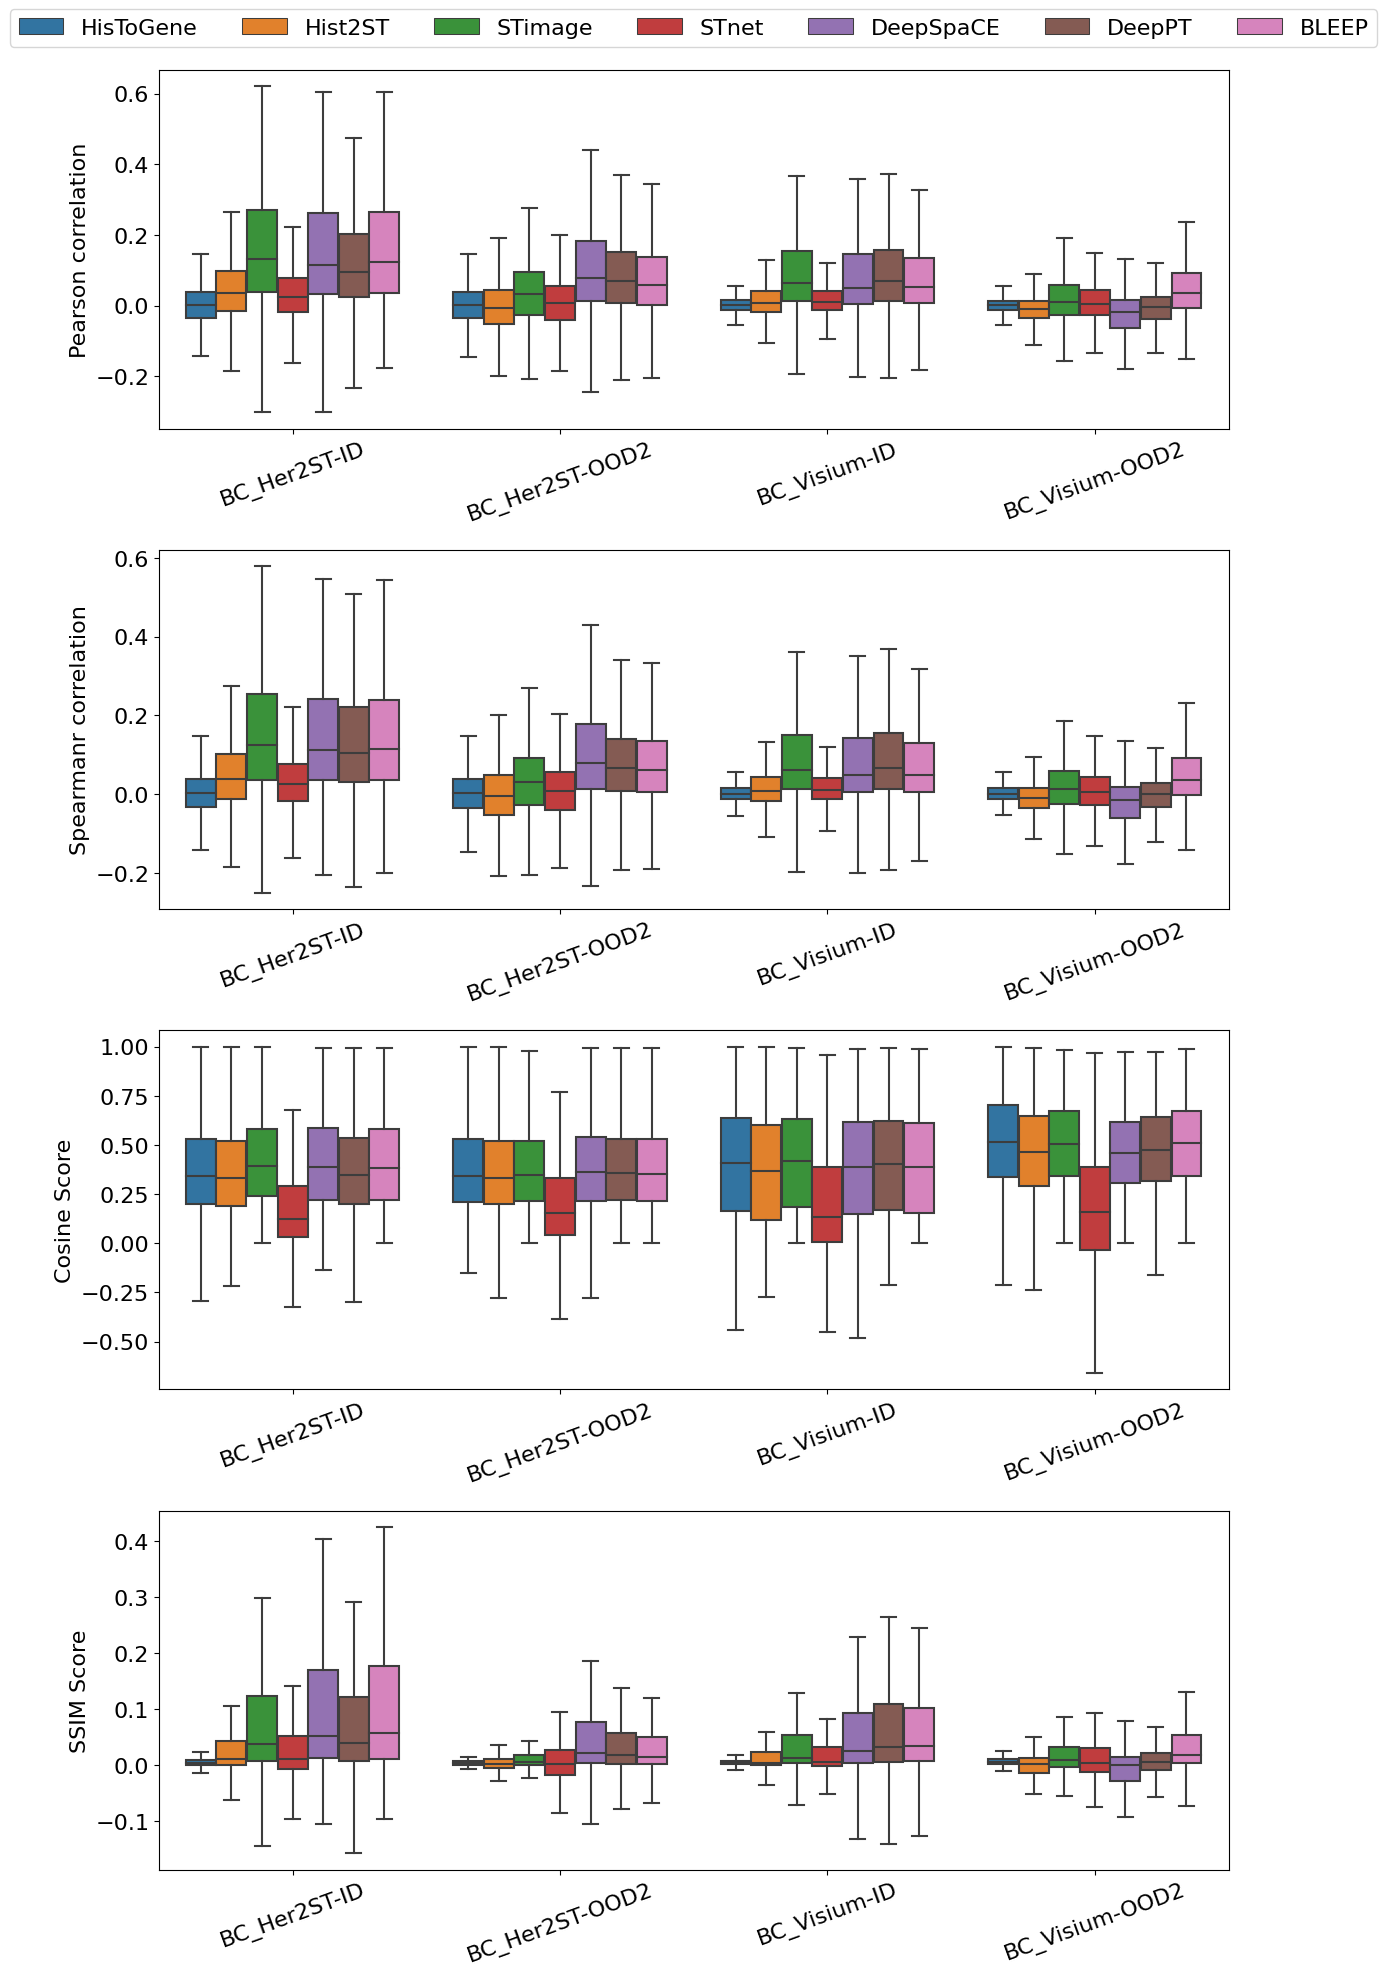

61700

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt
import gc

# Collect garbage to free up memory
gc.collect()

# Set the font size for better readability
plt.rcParams.update({'font.size': 16})

# Create subplots with 4 rows and 1 column
fig, axs = plt.subplots(4, 1, figsize=(14, 20))

# List of columns and corresponding y-axis labels for plotting
columns_to_plot = [
    ('Pearson correlation', 'Pearson correlation', True),
    ('Spearmanr correlation', 'Spearmanr correlation', False),
    ('Cosine_Score', 'Cosine Score', False),
    # ("Moran'I_Score", "Moran's I Score", False),
    ('SSIM_Score', 'SSIM Score', False),
]

# Loop through the columns and plot on the corresponding subplot
for i, (column, ylabel, add_legend) in enumerate(columns_to_plot):
    sns.boxplot(x='Dataset', y=column, hue='Method', data=df3, ax=axs[i], showfliers=False, orient="v")
    
    # Rotate x-axis labels with 10 degrees
    axs[i].tick_params(axis='x', labelrotation=20)
    
    # Remove legend for all subplots except the first one
    if not add_legend:
        axs[i].get_legend().remove()
    
    axs[i].set_xlabel('')  # Remove x label for all subplots
    
    # Set y-axis label
    axs[i].set_ylabel(ylabel)

# Move the legend outside the plot area only for the first subplot
pos = axs[0].get_position()
axs[0].set_position([pos.x0, pos.y0, pos.width, pos.height * 1])
axs[0].legend(
    loc='upper center',
    bbox_to_anchor=(0.5, 1.2),
    ncol=7,
)

# Adjust layout to prevent overlapping
plt.tight_layout()

# Save the plots as a PDF file
# plt.savefig("FigureS5.pdf", dpi=300)

# Show the plots
plt.show()

# Collect garbage to free up memory
gc.collect()


# Figure S5

## Predictable genes

In [106]:
# Specify the directory for functional gene results
functional_results_directory = "../Results/Summary/"

# Specify the directory for predictable gene results
predictable_results_directory = "../Results/Predictable_res/"

# List of dataset names
datasets = ['BC_Her2ST-ID', 'BC_Visium-ID', 'Skin_Melanoma-ID', 'Skin_cSCC-ID', 
            'BC_Her2ST-OOD', 'Skin_Melanoma-OOD', 'BC_Visium-OOD', 'Skin_cSCC-OOD']

# Iterate over datasets
for dataset_name in datasets:
    # Read the functional gene results for the current dataset
    df_func = df2[df2["Dataset"]==dataset_name]

    # List of methods
    methods = ['HisToGene', 'Hist2ST', 'STimage', 'STnet', 'DeepSpaCE', 'DeepPT', 'BLEEP']

    # Get predictable genes for each method
    predictable_genes_sets = [set(top_predictable_genes(df_func, dataset_name, method, num=500).index) for method in methods]

    # Find the intersection of predictable genes across all methods
    predictable_genes = list(set.intersection(*predictable_genes_sets))
    print(f"There are {len(predictable_genes)} genes that are predictable by all methods for {dataset_name}.")

    # Subset the original DataFrame for predictable genes
    df_predictable = df_func[df_func["Gene"].isin(predictable_genes)].reset_index(drop=True)

    # Save the results for predictable genes
    predictable_results_path = os.path.join(predictable_results_directory, f"predictable_{dataset_name}_OOD.csv")
    df_predictable.to_csv(predictable_results_path)

# Load the results of predictable genes
predictable_results_glob = os.path.join(predictable_results_directory, "predictable_*-*_OOD.csv")
df_combined_predictable = pd.concat([pd.read_csv(r, index_col=[0]) for r in glob.glob(predictable_results_glob)], ignore_index=True)
df_combined_predictable


There are 115 genes that are predictable by all methods for BC_Her2ST-ID.
There are 58 genes that are predictable by all methods for BC_Visium-ID.
There are 152 genes that are predictable by all methods for Skin_Melanoma-ID.
There are 110 genes that are predictable by all methods for Skin_cSCC-ID.
There are 43 genes that are predictable by all methods for BC_Her2ST-OOD.
There are 23 genes that are predictable by all methods for Skin_Melanoma-OOD.
There are 3 genes that are predictable by all methods for BC_Visium-OOD.
There are 1 genes that are predictable by all methods for Skin_cSCC-OOD.


,Unnamed: 0,index,Gene,Pearson correlation,PCC_PValue,Spearmanr correlation,SPC_PValue,SSIM_Score,Cosine_Score,Moran'I_Score,Slides,Dataset,Method
0,399175.0,7.0,TNFSF10,0.245483,6.368130e-55,0.254419,5.691491e-59,0.250289,0.850828,0.216137,block2,BC_Visium-ID,STnet
1,399180.0,12.0,CHD4,0.192932,2.565533e-34,0.190932,1.224923e-33,0.136564,0.561509,0.163842,block2,BC_Visium-ID,STnet
2,399220.0,52.0,RRM2,0.038338,8.325891e-03,0.043287,3.428728e-03,0.046833,0.626540,0.033823,block2,BC_Visium-ID,STnet
3,399277.0,109.0,NSD1,0.067529,1.217840e-05,0.067027,1.399649e-05,0.067774,0.462678,0.037629,block2,BC_Visium-ID,STnet
4,399343.0,175.0,USP9X,0.074344,1.677889e-06,0.075388,1.219553e-06,0.072930,0.561900,0.080433,block2,BC_Visium-ID,STnet
...,...,...,...,...,...,...,...,...,...,...,...,...,...
59103,NaN,NaN,KEAP1,0.203715,1.918621e-04,0.164375,2.154427e-03,0.130249,0.372220,NaN,D6,BC_Her2ST-OOD,STnet
59104,NaN,NaN,CUL3,0.114356,2.391153e-02,0.133170,1.052108e-02,-0.029815,-0.392298,NaN,D6,BC_Her2ST-OOD,STnet
59105,NaN,NaN,GSK3B,0.128501,1.301895e-02,0.121598,1.763870e-02,0.111138,0.361589,NaN,D6,BC_Her2ST-OOD,STnet
59106,NaN,NaN,SRSF2,0.082184,7.781541e-02,0.079472,8.488889e-02,0.077568,0.494646,NaN,D6,BC_Her2ST-OOD,STnet


In [107]:
method_order = ['STnet', 'HisToGene', 'Hist2ST', 'DeepSpaCE', 'STimage', 'BLEEP', 'DeepPT']
datasets = ['BC_Her2ST-ID', 'BC_Visium-ID', 'Skin_Melanoma-ID', 'Skin_cSCC-ID', 
            'BC_Her2ST-OOD', 'Skin_Melanoma-OOD', 'BC_Visium-OOD', 'Skin_cSCC-OOD']

df_combined_predictable['Method'] = pd.Categorical(df_combined_predictable['Method'], categories=method_order, ordered=True)
df_combined_predictable['Dataset'] = pd.Categorical(df_combined_predictable['Dataset'], categories=dataset_order, ordered=True)


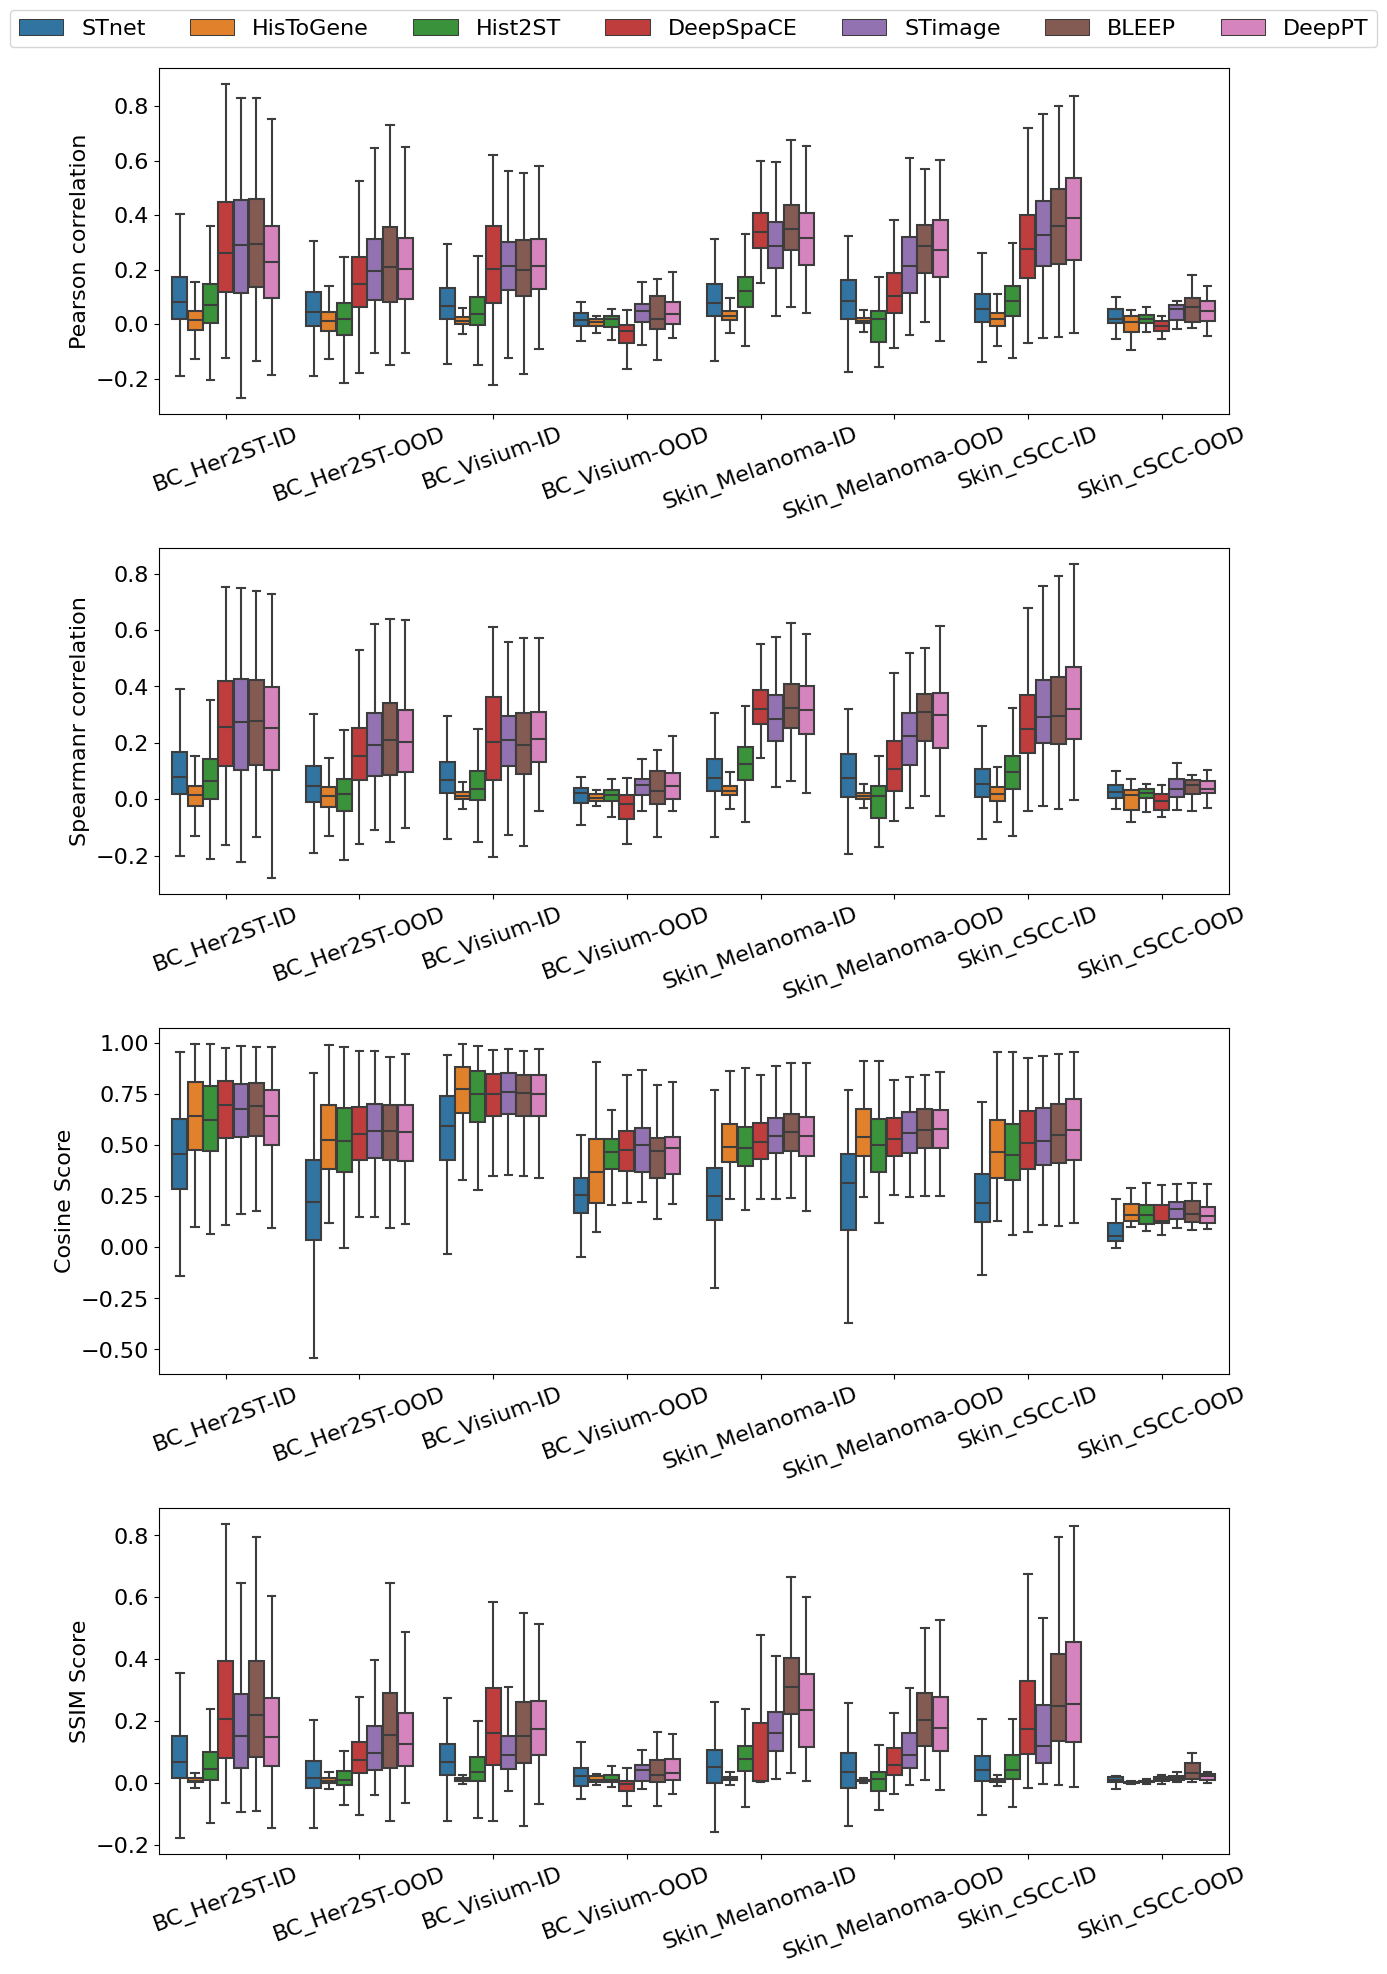

109039

In [108]:
# Collect garbage to free up memory
gc.collect()

# Set the font size for better readability
plt.rcParams.update({'font.size': 16})

# Create subplots with 4 rows and 1 column
fig, axs = plt.subplots(4, 1, figsize=(14, 20))

# List of columns and corresponding y-axis labels for plotting
columns_to_plot = [
    ('Pearson correlation', 'Pearson correlation', True),
    ('Spearmanr correlation', 'Spearmanr correlation', False),
    ('Cosine_Score', 'Cosine Score', False),
    # ("Moran'I_Score", "Moran's I Score", False),
    ('SSIM_Score', 'SSIM Score', False),
]

# Loop through the columns and plot on the corresponding subplot
for i, (column, ylabel, add_legend) in enumerate(columns_to_plot):
    sns.boxplot(x='Dataset', y=column, hue='Method', data=df_combined_predictable, ax=axs[i], showfliers=False, orient="v")
    
    # Rotate x-axis labels with 10 degrees
    axs[i].tick_params(axis='x', labelrotation=20)
    
    # Remove legend for all subplots except the first one
    if not add_legend:
        axs[i].get_legend().remove()
    
    axs[i].set_xlabel('')  # Remove x label for all subplots
    
    # Set y-axis label
    axs[i].set_ylabel(ylabel)

# Move the legend outside the plot area only for the first subplot
pos = axs[0].get_position()
axs[0].set_position([pos.x0, pos.y0, pos.width, pos.height * 1])
axs[0].legend(
    loc='upper center',
    bbox_to_anchor=(0.5, 1.2),
    ncol=7,
)

# Adjust layout to prevent overlapping
plt.tight_layout()

# Save the plots as a PDF file
# plt.savefig("Figure4.pdf")

# Show the plots
plt.show()

# Collect garbage to free up memory
gc.collect()
